In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [118]:
smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.patches smuggle Rectangle
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1
from sklearn.linear_model smuggle LinearRegression
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance smuggle cdist                 # pip: scipy==1.10.1
from scipy.io smuggle loadmat
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings

Download and load data

In [3]:
basedir = os.path.split(os.path.split(os.getcwd())[0])[0]
datadir = os.path.join(basedir, 'data')
figdir = os.path.join(basedir, 'paper', 'figs', 'source')

url = 'https://www.dropbox.com/s/29a48lv3j5ybcvw/pieman2_htfa.pkl?dl=1'

fname = os.path.join(datadir, 'pieman2_htfa.pkl')
if not os.path.exists(fname):
    with open(fname, 'wb') as f:
        data = requests.get(url).content
        f.write(data)

with open(fname, 'rb') as f:
    data = pickle.load(open(fname, 'rb'))

conditions = list(data['weights'].keys())

Load (computing and saving as needed) the reduced versions of the data using $k \in \{3, 4, 5, ..., 700\}$ components

In [4]:
def group_pca(data, n_components=None, fname=None):
    if fname is not None:
        if os.path.exists(fname):
            with open(fname, 'rb') as f:
                return pickle.load(f)
    
    pca = PCA(n_components=n_components)
    
    x = dw.stack(data)
    y = pca.fit_transform(x)

    y = dw.unstack(pd.DataFrame(index=x.index, data=y))

    if fname is not None:
        with open(fname, 'wb') as f:
            pickle.dump((y, pca), f)
    
    return y, pca

In [5]:
scratch_dir = os.path.join(basedir, 'data', 'scratch')
if not os.path.exists(scratch_dir):
    os.makedirs(scratch_dir)

reduced_data = {'full': {}}
max_components = data['weights']['intact'][0].shape[1]

n_parts = 4
for i in range(n_parts):
    reduced_data[f'pt{i}'] = {}

for c in conditions:
    reduced_data['full'][c] = {}

    for i in range(n_parts):
        reduced_data[f'pt{i}'][c] = {}
    
    chunk_size = data['weights'][c][0].shape[0] // n_parts

    for n in tqdm(range(3, max_components + 1)):
        # full time range
        fname = os.path.join(scratch_dir, f'pca_full_{c}_{n}.pkl')
        reduced_data['full'][c][n], _ = group_pca(data['weights'][c], n_components=n, fname=fname)
        
        # chunked time range
        for i in range(n_parts):
            fname = os.path.join(scratch_dir, f'pca_pt{i + 1}_of_{n_parts}_{c}_{n}.pkl')
            chunk_start = i * chunk_size
            if i < n_parts - 1:                
                chunk_end = (i + 1) * chunk_size
            else:
                chunk_end = data['weights'][c][0].shape[0]
            
            next_chunk = [x.iloc[chunk_start:chunk_end] for x in data['weights'][c]]
            reduced_data[f'pt{i}'][c][n], _ = group_pca(next_chunk, n_components=n, fname=fname)
    
    data['weights'].pop(c)


100%|██████████| 698/698 [00:40<00:00, 17.41it/s]


In [6]:
def accuracy(train, test):
    train = np.mean(np.stack(train, axis=2), axis=2)
    test = np.mean(np.stack(test, axis=2), axis=2)
    dists = cdist(train, test, metric='correlation')
    
    labels = np.argmin(dists, axis=1)
    return np.mean([i == d for i, d in enumerate(labels)]) - 1 / len(labels)

In [7]:
def cross_validation(data, n_iter=10, fname=None):
    if fname is not None:
        if os.path.exists(fname):
            with open(fname, 'rb') as f:
                return pickle.load(f)

    results = pd.DataFrame(columns=['Iteration', 'Number of components', 'Relative decoding accuracy'])

    n = len(data[3]) // 2
    for i in tqdm(range(n_iter)):
        order = np.random.permutation(len(data[3]))

        for c in range(3, max_components + 1):
            x = pd.DataFrame(columns=['Iteration', 'Number of components', 'Relative decoding accuracy'])
            x.loc[0, 'Iteration'] = i
            x.loc[0, 'Number of components'] = c

            train = [data[c][o] for o in order[:n]]
            test = [data[c][o] for o in order[n:]]
            x.loc[0, 'Relative decoding accuracy'] = (accuracy(train, test) + accuracy(test, train)) / 2

            results = pd.concat([results, x], ignore_index=True)
    
    if fname is not None:
        with open(fname, 'wb') as f:
            pickle.dump(results, f)
    
    return results

In [8]:
condition_colors = {
    'intact': '#21409A',
    'paragraph': '#00A14B',
    'word': '#FFDE17',
    'rest': '#7F3F98'
}

In [9]:
n_iter = 100

decoding_results = {'full': {}}
for i in range(n_parts):
    decoding_results[f'pt{i}'] = {}

for c in conditions:
    # full time range
    fname = os.path.join(scratch_dir, f'decoding_results_{n_iter}_full_{c}.pkl')
    decoding_results['full'][c] = cross_validation(reduced_data['full'][c], n_iter=n_iter, fname=fname)

    # chunked time range
    for i in range(n_parts):
        fname = os.path.join(scratch_dir, f'decoding_results_{n_iter}_pt{i + 1}_of_{n_parts}_{c}.pkl')
        decoding_results[f'pt{i}'][c] = cross_validation(reduced_data[f'pt{i}'][c], n_iter=n_iter, fname=fname)

100%|██████████| 100/100 [13:00<00:00,  7.81s/it]


In [10]:
def plot_accuracy(x, fname=None):
    if not os.path.exists(figdir):
        os.makedirs(figdir)

    fig = plt.figure(figsize=(4, 3))
    ax = plt.gca()

    for c in conditions:
        sns.lineplot(x[c], x='Number of components', y='Relative decoding accuracy', label=c.capitalize(), color=condition_colors[c], legend=False)
    
    ax.set_xlabel('Number of components', fontsize=12)
    ax.set_ylabel('Relative decoding accuracy', fontsize=12)
    ax.set_ylim(-0.01, 0.35)
    ax.set_xlim(3, 700)
    ax.spines[['right', 'top']].set_visible(False)

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')

    return fig

In [99]:
def info_and_compressibility(d, target=0.05):
    def closest(x, target):
        dists = np.abs(x.values - target)
        return int(x.index.values[np.argmin(dists)])

    df = []
    for c in conditions:
        dc = d[c].astype(float).pivot(index='Iteration', columns='Number of components', values='Relative decoding accuracy')
        i = pd.DataFrame()
        i['Number of components'] = dc.apply(lambda x: closest(x, target), axis=1, raw=False)
        i['Relative decoding accuracy'] = dc.max(axis=1)
        i['Condition'] = c
        i['Iteration'] = dc.index.values.astype(int)
        df.append(i)
    return pd.concat(df, ignore_index=True, axis=0)

In [100]:
def plot_info_and_compressibility_scatter(x, fname=None):
    fig = plt.figure(figsize=(4, 3))
    ax = plt.gca()

    x = info_and_compressibility(x)
    sns.scatterplot(x, x='Number of components', y='Relative decoding accuracy', hue='Condition', palette=[condition_colors[c] for c in conditions], legend=False, s=10, ax=ax)
    sns.scatterplot(x.groupby('Condition').mean().loc[conditions].reset_index(), x='Number of components', y='Relative decoding accuracy', hue='Condition', palette=[condition_colors[c] for c in conditions], legend=False, s=100, ax=ax)

    ax.set_xlabel('Number of components', fontsize=12)
    ax.set_ylabel('Relative decoding accuracy', fontsize=12)
    ax.set_ylim(-0.01, 0.35)
    ax.set_xlim(3, 700)

    ax.spines[['right', 'top']].set_visible(False)

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

In [214]:
def ridge_plot(x, column='Number of components', fname=None, xlim=[-99, 700]):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    g = sns.FacetGrid(x, row='Condition', hue='Condition', palette=[condition_colors[c] for c in conditions], height=1, aspect=6)
    g.map(sns.kdeplot, column, bw_adjust=1, clip_on=True, fill=True, alpha=1, common_norm=True, linewidth=1.5)
    g.refline(y=0, linewidth=1.5, linestyle='-', color=None, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.2, label.capitalize(), fontweight='bold', color=color, ha='left', va='center', transform=ax.transAxes)

    g.map(label, 'Condition')

    g.figure.subplots_adjust(hspace=-0.5)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    ax = plt.gca()
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_xlabel(column, fontsize=12)

    if fname is not None:
        g.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')

# Figure 2A

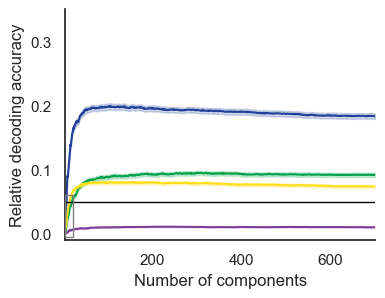

In [140]:
fig = plot_accuracy(decoding_results['full']);
ax = plt.gca()

ax.plot([0, 700], [0.05, 0.05], '-', color='black', linewidth=1)
ax.add_patch(Rectangle((3, -0.005), 17, 0.065, fill=False, edgecolor='gray', linewidth=1, zorder=3))

fig.savefig(os.path.join(figdir, 'decoding_full.pdf'), bbox_inches='tight')


# Figure 2B

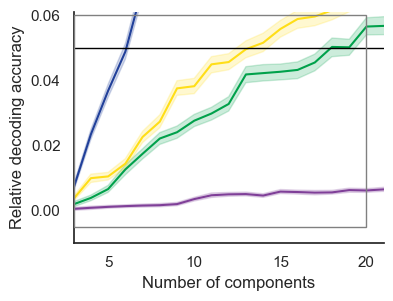

In [145]:
fig = plot_accuracy(decoding_results['full']);
ax = plt.gca()

ax.plot([0, 700], [0.05, 0.05], '-', color='black', linewidth=1)
ax.add_patch(Rectangle((3, -0.005), 17, 0.065, fill=False, edgecolor='gray', linewidth=1, zorder=3))
ax.set_xlim(3, 21)
ax.set_ylim(-0.01, 0.061)

fig.savefig(os.path.join(figdir, 'decoding_full_zoomed.pdf'), bbox_inches='tight')

# Figure 2C

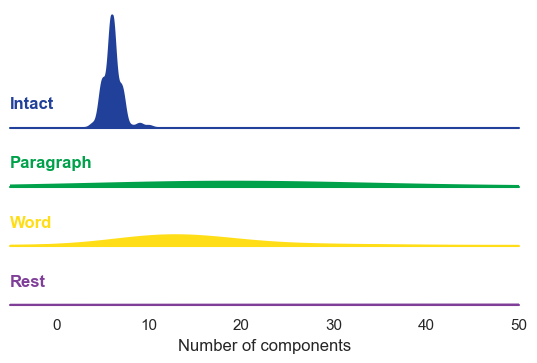

In [221]:
ridge_plot(info_and_compressibility(decoding_results['full'], target=0.05), column='Number of components', xlim=[-5, 50], fname='n_components_dists_full')

# Figure 2D

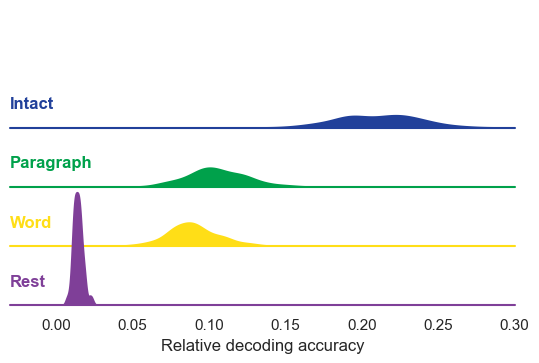

In [222]:
ridge_plot(info_and_compressibility(decoding_results['full']), column='Relative decoding accuracy', xlim=[-0.03, 0.3], fname='decoding_accuracy_dists_full')

# Figure 2E

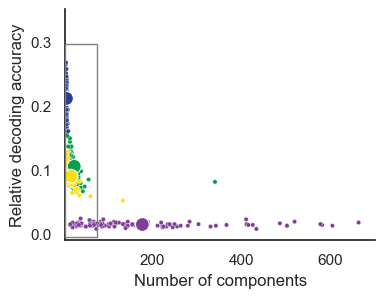

In [244]:
fig = plot_info_and_compressibility_scatter(decoding_results['full']);
ax = plt.gca()
ax.add_patch(Rectangle((3, -0.005), 72, 0.3, fill=False, edgecolor='gray', linewidth=1, zorder=3))

fig.savefig(os.path.join(figdir, 'decoding_full_scatter.pdf'), bbox_inches='tight')


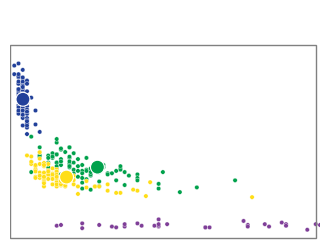

In [245]:
ax.set_xlim(3, 76)
ax.set_axis_off()
fig.savefig(os.path.join(figdir, 'decoding_full_scatter_inset.pdf'), bbox_inches='tight')
fig


# Figure 3A

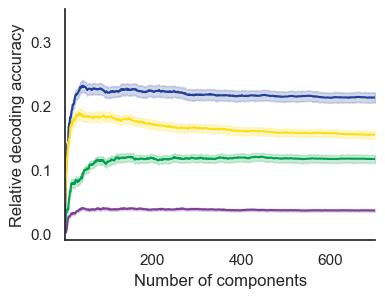

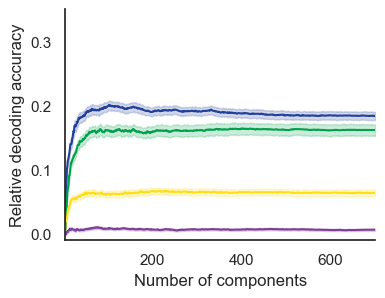

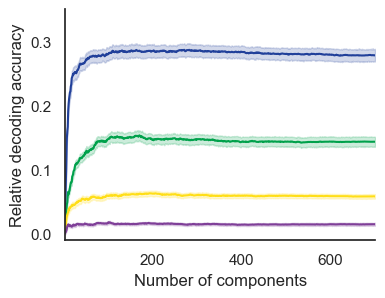

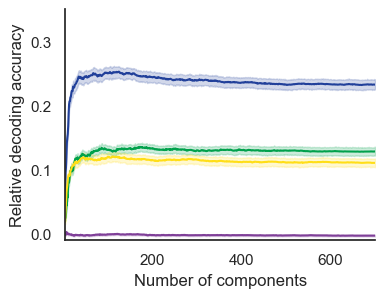

In [19]:
for i in range(n_parts):
    plot_accuracy(decoding_results[f'pt{i}'], fname=f'decoding_pt{i + 1}_of_{n_parts}');

# Figure 3B

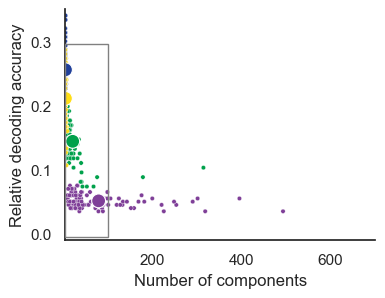

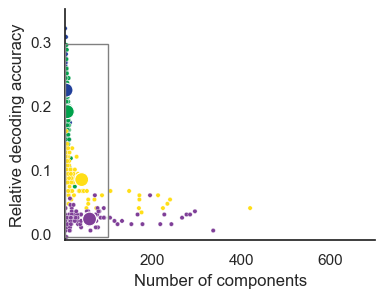

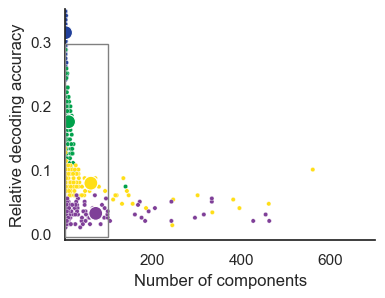

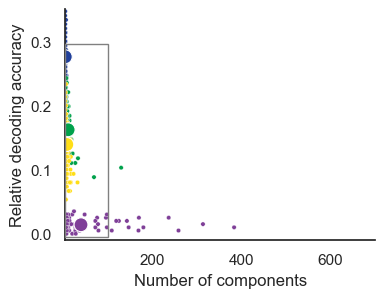

In [246]:
for i in range(n_parts):
    fig = plot_info_and_compressibility_scatter(decoding_results[f'pt{i}']);
    ax = plt.gca()
    ax.add_patch(Rectangle((3, -0.005), 97, 0.3, fill=False, edgecolor='gray', linewidth=1, zorder=3))

    fig.savefig(os.path.join(figdir, f'decoding_pt{i + 1}_of_{n_parts}_scatter.pdf'), bbox_inches='tight')



# Fig 3B insets

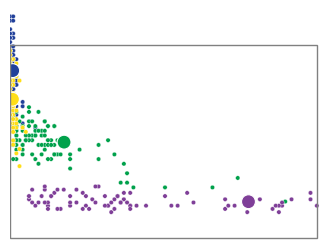

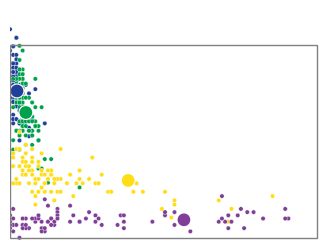

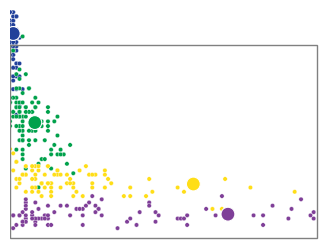

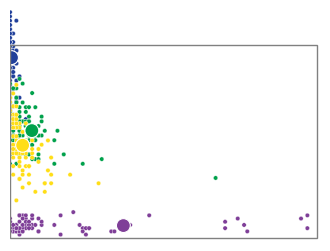

In [247]:
for i in range(n_parts):
    fig = plot_info_and_compressibility_scatter(decoding_results[f'pt{i}']);
    ax = plt.gca()
    ax.add_patch(Rectangle((3, -0.005), 97, 0.3, fill=False, edgecolor='gray', linewidth=1, zorder=3))

    ax.set_xlim(3, 101)
    ax.set_axis_off()
    fig.savefig(os.path.join(figdir, f'decoding_pt{i + 1}_of_{n_parts}_scatter_inset.pdf'), bbox_inches='tight')
    fig


# Change analysis (Fig 3C)

In [23]:
def accuracy_slopes(parts, fname=None):
    if fname is not None:
        if os.path.exists(fname):
            with open(fname, 'rb') as f:
                return pickle.load(f)

    components = np.unique(parts[0]['intact']['Number of components']).astype(int)
    iterations = np.unique(parts[0]['intact']['Iteration']).astype(int)
    df = []

    x = np.arange(len(parts)).reshape(-1, 1)

    for c in conditions:
        for i in tqdm(iterations):
            for n in components:
                y = []
                for p in parts:
                    y.append(p[c].query('Iteration == @i & `Number of components` == @n')['Relative decoding accuracy'].values.astype(float))
                y = np.array(y).reshape(-1, 1)

                # note: I'm not sure why the commented out code below doesn't work, whereas the above does...
                # y = pd.concat([p[c].query('Iteration == @i & `Number of components` == @n') for p in parts], axis=0).copy()['Relative decoding accuracy'].values.astype(float).reshape(-1, 1)

                regression = LinearRegression().fit(x, y)
                
                r = pd.Series(dtype=float)
                r['Number of components'] = n
                r['Slope'] = float(regression.coef_)
                r['Condition'] = c
                
                df.append(pd.DataFrame(r).T)
    
    df = pd.concat(df, ignore_index=True, axis=0)

    if fname is not None:
        with open(fname, 'wb') as f:
            pickle.dump(df, f)
    
    return df

In [233]:
slopes = accuracy_slopes([decoding_results[f'pt{i}'] for i in range(n_parts)], fname=os.path.join(scratch_dir, f'decoding_slopes_{n_iter}.pkl'))

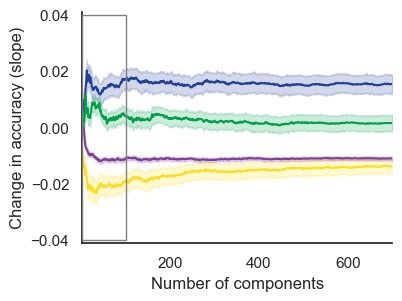

In [249]:
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

sns.lineplot(slopes, x='Number of components', y='Slope', hue='Condition', palette=[condition_colors[c] for c in conditions], legend=False)

ax.set_xlabel('Number of components', fontsize=12)
ax.set_ylabel('Change in accuracy (slope)', fontsize=12)
ax.set_ylim(-0.041, 0.041)
ax.set_xlim(3, 700)
ax.spines[['right', 'top']].set_visible(False)

ax.add_patch(Rectangle((3, -0.04), 97, 0.08, fill=False, edgecolor='gray', linewidth=1, zorder=3))

fig.savefig(os.path.join(figdir, 'decoding_slopes.pdf'), bbox_inches='tight')

# Fig 3C inset

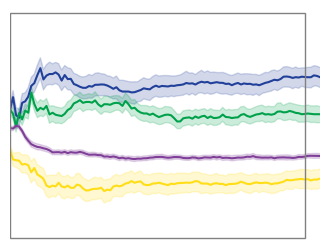

In [250]:
ax.set_xlim([3, 105])
ax.set_axis_off()
fig.savefig(os.path.join(figdir, 'decoding_slopes_zoomed.pdf'), bbox_inches='tight')
fig